## Mask
Create patch of sky near the south pole

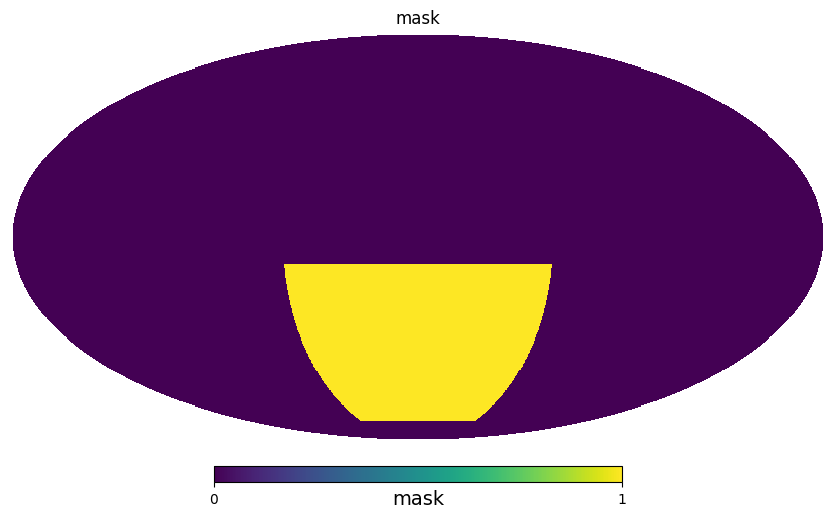

In [121]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Parameters
nside = 256 
ra_min, ra_max = -60.0, 60.0   # degrees
dec_min, dec_max = -75.0, -10.0  # degrees

# Convert to HEALPix angles
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix), lonlat=False)
ra = np.degrees(phi)
dec = 90.0 - np.degrees(theta)

# wrap RA to [-180, 180]
ra = ((ra + 180) % 360) - 180

# Build mask
mask = (
    (ra >= ra_min) & (ra <= ra_max) &
    (dec >= dec_min) & (dec <= dec_max)
).astype(np.uint8)

hp.mollview(mask, title="mask", unit="mask")


In [283]:
# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_sync_maps.npy")
noise=np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")[:-1]

In [179]:
# hi=np.load('/home/iloveorcas/MASS_Thesis/results_2/hi_maps.npy')
hi_cl2=np.load('/home/iloveorcas/SMICA_Paper/Notebooks_1/cal_hi_cov_mK.npy')
cl_hi = np.transpose(hi_cl2, (2, 0, 1))
hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/hi_maps_mK.npy")

In [180]:
hi_cl2.shape

(55, 55, 768)

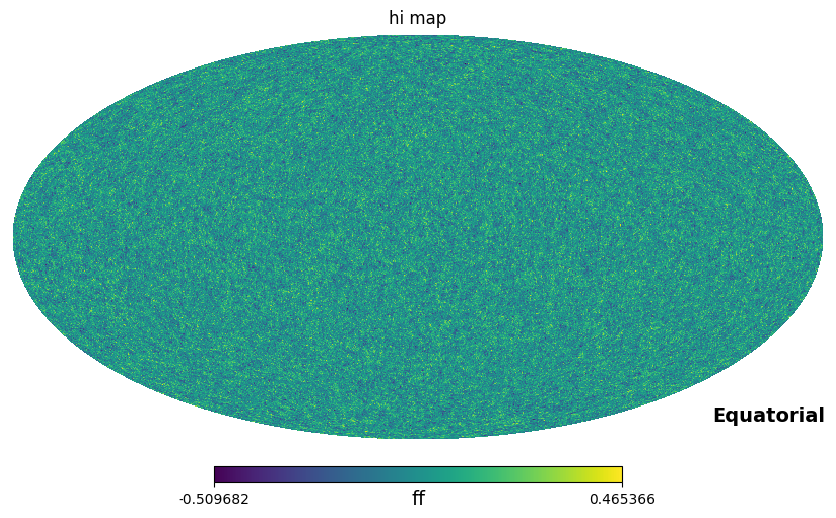

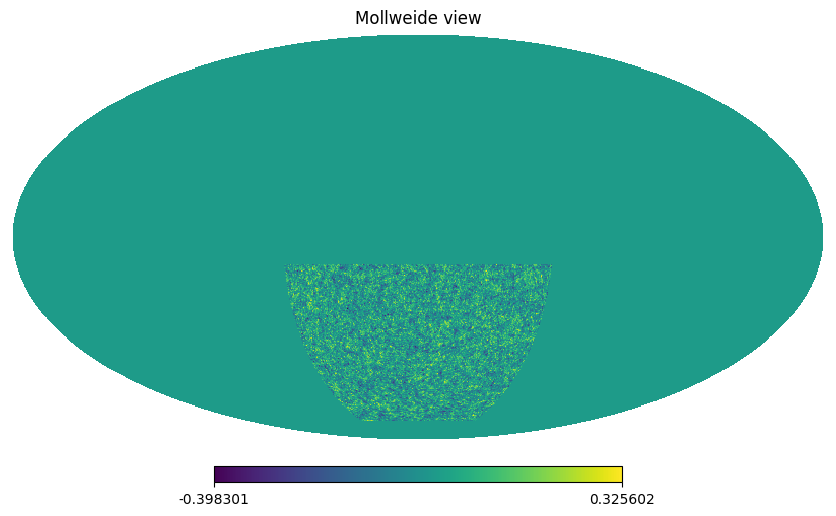

In [181]:
hp.mollview(hi_maps[0], coord=['G', 'C'], title="hi map", unit="ff")
rot=hp.rotator.Rotator(coord=['G', 'C'])
rotated_h=rot.rotate_map_pixel(hi_maps[0])

hp.mollview(rotated_h*mask)

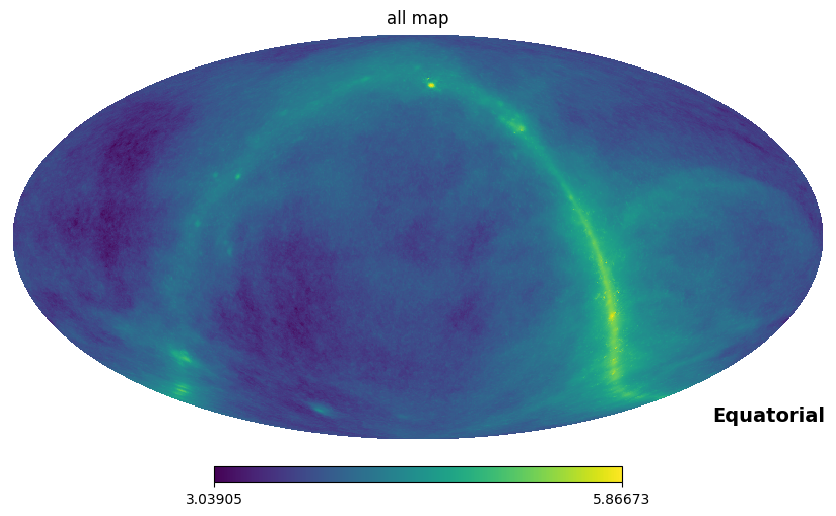

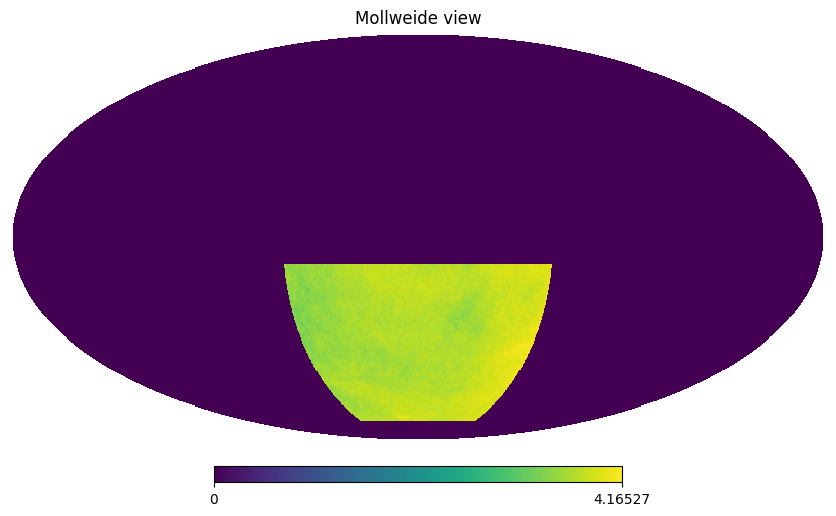

In [182]:
hp.mollview(np.log10(sync[0]*1e-3+ff[0]*1e-3+ hi_maps[0]), coord=['G', 'C'], title="all map")
# rot_s=hp.rotator.Rotator(coord=['G', 'C'])
rotated_a=rot.rotate_map_pixel((sync[0] +ff[0])*1e-3 + hi_maps[0])

hp.mollview((np.log10(rotated_a))*mask)

In [296]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)
r=3 #foreground model rank
# n_bins=10
bin_width=10

fgds=(ff+sync)*1e-3 #mK
signal= fgds + hi_maps[:-1] +noise

In [285]:
np.mean(signal)/np.mean(noise)

np.float64(115119826098.30925)

## Rotate Maps

In [297]:
def rotate_maps(map: np.ndarray)-> np.ndarray:
    """Convert maps frequency by frequency from galactic coordinates to celestial/equatorial coordinates

    Args:
        map : map in pixels to be rotated
    """
    rot=hp.rotator.Rotator(coord=['G', 'C'])
    rotated=np.zeros_like(map)
    for i in range(nfreqs):
        # print(f"Rotating map {i+1}")
        rotated[i]=rot.rotate_map_pixel(map[i])
    return rotated

rotated_fgds=rotate_maps(fgds)
rotated_hi=rotate_maps(hi_maps[:-1])
rotated_noise=rotate_maps(noise)
rotated_sky= rotate_maps(signal)

## Mask maps

In [298]:
import sys
sys.path.append('../')
from scripts.mask_maps import mask_maps
fgds_masked,_= mask_maps(rotated_fgds, mask,almsize, lmax, nfreqs,  npix)
hi_masked,_= mask_maps(rotated_hi, mask,almsize, lmax, nfreqs,  npix)
noise_masked,_= mask_maps(rotated_noise, mask,almsize, lmax, nfreqs,  npix)
sky_masked,_= mask_maps(rotated_sky, mask,almsize, lmax, nfreqs,  npix)

In [ ]:
from scripts.compute_covariance import compute_covariance

fgds_cl= compute_covariance(fgds_masked, lmax,almsize, nfreqs)
hi_cl= compute_covariance(hi_masked, lmax,almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [299]:
noise_cl= compute_covariance(noise_masked, lmax,almsize, nfreqs)
sky_cl= compute_covariance(sky_masked, lmax,almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

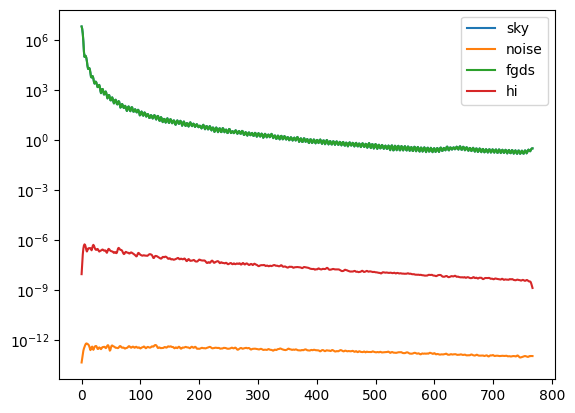

In [300]:
plt.plot(sky_cl[:,0,0], label='sky')   
plt.plot(noise_cl[:,0,0], label='noise')
plt.plot(fgds_cl[:,0,0], label='fgds')
plt.plot(hi_cl[:,0,0], label='hi')
plt.legend()
plt.yscale('log')

## Decouple and bin spectra

In [301]:
import pymaster as nmt
def compute_decoupled_cl( maps: np.ndarray, masks:np.ndarray, l_max:int, n_freq:int)-> np.ndarray:
    """
    Compute the power spectra using NaMaster for a set of frequency maps.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - X: flag to indicate if the input maps are masked
    - nsides: resolution parameter for the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels

    Returns:
    - p_cl: raw power spectrum (coupled)
    - matrix: mode coupling matrix
    - cldec: decoupled power spectrum
    """

    cldec = np.zeros((l_max//bin_width, n_freq, n_freq))
    
    
    # Define a NaMaster binning scheme (no binning)
    b = nmt.NmtBin.from_lmax_linear(l_max, bin_width)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print ("processing map %d" % i)
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)
            
            # Define the masked fields for the two maps
            f_i = nmt.NmtField(masks, [maps[i, :]], lmax=l_max) 
            f_j = nmt.NmtField( masks, [maps[j, :]], lmax=l_max) 
            
            cldec[:,i,j]=nmt.compute_full_master(f_i, f_j, b)

            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
    
    return leff,n_bins,cldec

In [ ]:
*_,dec_fgds= compute_decoupled_cl(fgds_masked, mask, lmax, nfreqs)
*_,dec_hi= compute_decoupled_cl(hi_masked, mask, lmax, nfreqs)


processing map 0
processing map 1
processing map 2
processing map 3
processing map 4
processing map 5
processing map 6
processing map 7
processing map 8
processing map 9
processing map 10
processing map 11
processing map 12
processing map 13
processing map 14
processing map 15
processing map 16
processing map 17
processing map 18
processing map 19
processing map 20
processing map 21
processing map 22
processing map 23
processing map 24
processing map 25
processing map 26
processing map 27
processing map 28
processing map 29
processing map 30
processing map 31
processing map 32
processing map 33
processing map 34
processing map 35
processing map 36
processing map 37
processing map 38
processing map 39
processing map 40
processing map 41
processing map 42
processing map 43
processing map 44
processing map 45
processing map 46
processing map 47
processing map 48
processing map 49
processing map 50
processing map 51
processing map 52
processing map 53
processing map 0
processing map 1
proc

In [302]:
*_, dec_noise= compute_decoupled_cl(noise_masked, mask, lmax, nfreqs)
leff,n_bins, dec_sky= compute_decoupled_cl(sky_masked, mask, lmax, nfreqs)

processing map 0
processing map 1
processing map 2
processing map 3
processing map 4
processing map 5
processing map 6
processing map 7
processing map 8
processing map 9
processing map 10
processing map 11
processing map 12
processing map 13
processing map 14
processing map 15
processing map 16
processing map 17
processing map 18
processing map 19
processing map 20
processing map 21
processing map 22
processing map 23
processing map 24
processing map 25
processing map 26
processing map 27
processing map 28
processing map 29
processing map 30
processing map 31
processing map 32
processing map 33
processing map 34
processing map 35
processing map 36
processing map 37
processing map 38
processing map 39
processing map 40
processing map 41
processing map 42
processing map 43
processing map 44
processing map 45
processing map 46
processing map 47
processing map 48
processing map 49
processing map 50
processing map 51
processing map 52
processing map 53
processing map 0
processing map 1
proc

In [ ]:
# np.save('dec_fgds.npy', dec_fgds)
# np.save('dec_hi.npy', dec_hi)
# np.save('dec_noise.npy', dec_noise)
# np.save('dec_sky.npy', dec_sky)

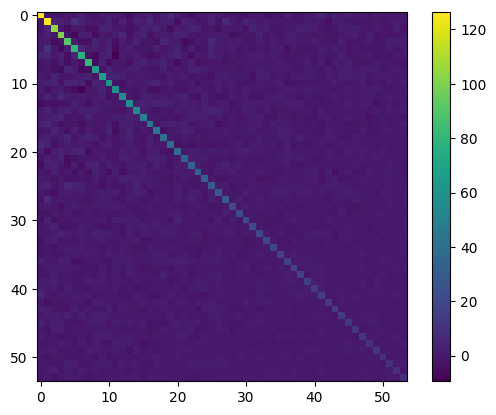

In [303]:
plt.imshow(dec_hi[30]/np.mean(dec_hi))
plt.colorbar()

In [ ]:
pixel=100


In [299]:
dec_hi.shape

(76, 54, 54)

In [304]:
norm=(leff*(leff+1))/2*np.pi
ells=np.arange(0, lmax+1)
norm2=(ells*(ells+1))/2*np.pi

Text(0.5, 0, '$\\ell$')

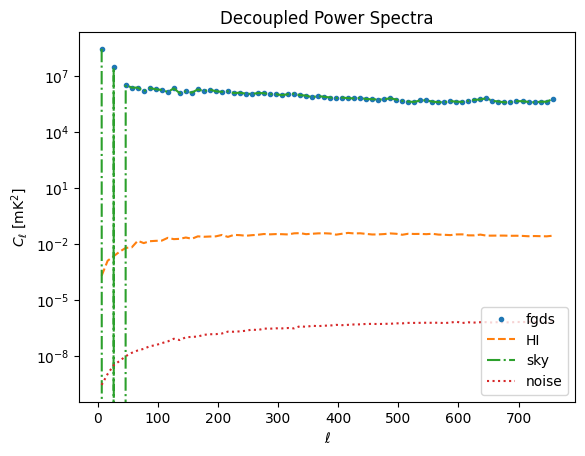

In [309]:
plt.plot(leff,norm*dec_fgds[:,0,0], '.',label='fgds')
plt.plot(leff,norm*dec_hi[:,0,0], '--', label='HI')
plt.plot(leff,norm*dec_sky[:,0,0], '-.', label='sky')
plt.plot(leff,norm*dec_noise[:,0,0], ':', label='noise')
# plt.plot(ells,cl_hi[2:,0,0]*norm2, label='hi cl unmasked')
plt.yscale('log')
# plt.plot( dec_fgds[5:,0,0]-dec_hi[5:,0,0], label='fgds - HI')
# plt.loglog()
plt.legend()
plt.title('Decoupled Power Spectra')
plt.ylabel(r'$C_\ell$ [mK$^2$]')
plt.xlabel(r'$\ell$')

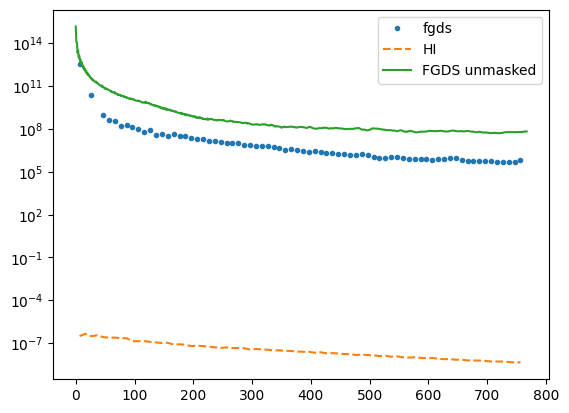

In [ ]:
# plt.plot(leff,dec_fgds[:,0,0], '.',label='fgds')
# plt.plot(leff,dec_hi[:,0,0], '--', label='HI')
# plt.yscale('log')
# plt.plot(cl_fgds_true, label='FGDS unmasked')
# # plt.plot( dec_fgds[5:,0,0]-dec_hi[5:,0,0], label='fgds - HI')
# # plt.loglog()
# plt.legend()
# #width 10

In [310]:
def bin_spectra(cl,nside, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    nbins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((nbins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,nbins,cl_binned

In [311]:
leff,n_bins, fgds_binned= bin_spectra(fgds_cl, nside, bin_width)
*_, hi_binned= bin_spectra(hi_cl, nside, bin_width)
*_, noise_binned= bin_spectra(noise_cl, nside, bin_width)
*_, sky_binned= bin_spectra(sky_cl, nside, bin_width)

In [312]:
cl_fgds_true = hp.anafast(fgds[0])

# Bin the true (unmasked) spectrum using the same binning scheme as used elsewhere
# (use NaMaster's bin object directly to bin the 1D spectrum)
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=bin_width)
true_fgds_binned = b.bin_cell(cl_fgds_true)

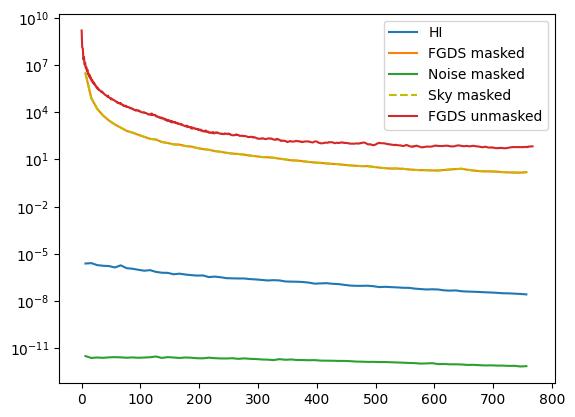

In [313]:
plt.plot(leff,hi_binned[:,0,0]/mask.mean(), label='HI')
plt.plot(leff,fgds_binned[:,0,0]/mask.mean(), label='FGDS masked')
plt.plot(leff,noise_binned[:,0,0]/mask.mean(), label='Noise masked')
plt.plot(leff,sky_binned[:,0,0]/mask.mean(), 'y--',label='Sky masked')
plt.plot(cl_fgds_true, label='FGDS unmasked')
# plt.plot(leff, dec_fgds[:,0,0], label='FGDS decoupled')
# plt.plot(leff,(true_fgds_binned-fgds_binned[:,0,0]), label='FGDS true - FGDS binned')
plt.yscale('log')
plt.legend()

In [314]:
sky_fraction =(mask**2).mean()
sky_fraction

np.float64(0.13221359252929688)

## PCA

In [315]:
def pca(empirical, r, f):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F_i = eigvecs[:, -r:]  # largest eigenvectors
    epsilon=1e-6

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] =np.dot( F_i.T , np.dot(empirical[b] , F_i)) #projecting the empirical covariance into the subspace spanned by F.
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T) + epsilon * np.eye(r)
    return eigvals,F_i, P_b*f


In [468]:
factor=700
_,F_pca, P_b_pca = pca(dec_sky,r, factor)
# F_pca, P_b_pca = guess_params(nfreqs, n_bins,r)
# e,F_pca, P_b_pca = pca_extended_random_fill(c_hat,5,2)
print(F_pca.shape)
print(P_b_pca.shape)
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])
print(params_pca.shape)

(54, 3)
(76, 3, 3)
(846,)


In [469]:
np.linalg.eigvalsh(dec_sky[4])

array([-3.70118459e-08,  7.30542829e-10,  1.10369165e-09,  7.59724195e-09,
        1.24776668e-08,  1.47980477e-08,  1.78097516e-08,  1.86141306e-08,
        2.51691129e-08,  3.05446621e-08,  3.50507350e-08,  3.73627498e-08,
        4.15425632e-08,  4.92746143e-08,  5.58157985e-08,  5.90678710e-08,
        6.33697929e-08,  6.63105272e-08,  7.77087501e-08,  8.17224060e-08,
        8.79544026e-08,  9.32796445e-08,  1.03180906e-07,  1.11886675e-07,
        1.27042590e-07,  1.31232151e-07,  1.32982337e-07,  1.44887508e-07,
        1.65375611e-07,  1.78295013e-07,  2.06756812e-07,  2.12008668e-07,
        2.25886910e-07,  2.30056729e-07,  2.77568656e-07,  3.41328488e-07,
        3.58469485e-07,  3.67876951e-07,  4.71655602e-07,  4.89400425e-07,
        5.38262072e-07,  6.10789503e-07,  6.91836628e-07,  7.32336538e-07,
        8.28249902e-07,  9.79797159e-07,  1.29354483e-06,  1.35620337e-06,
        1.39204856e-06,  1.73668268e-06,  2.05252409e-06,  1.74932428e-04,
        3.00153353e+00,  

## Build Model covariance

In [470]:
def model_covariance(F, P_b,C_HI,C_noise):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b,:,:] + C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b
c_model= model_covariance(F_pca, P_b_pca,dec_hi,dec_noise)

In [471]:
c_model.shape

(76, 54, 54)

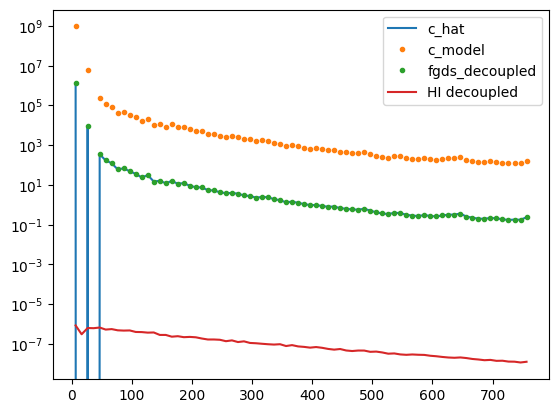

In [472]:
plt.plot(leff,dec_sky[:,10,10], label='c_hat')
plt.plot(leff,c_model[:,10,10],'.', label='c_model')
plt.plot(leff,dec_fgds[:,10,10],'.', label='fgds_decoupled')
# plt.plot(leff,dec_noise[:,10,10], label='noise_decoupled')
plt.plot(leff,dec_hi[:,10,10], label='HI decoupled')
plt.yscale('log')
plt.legend()

In [473]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(c_model))

Is model PSD? False


## define smica function and its jacobian

In [474]:
def smica(params):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    F_i = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((leff.size,r,r))

                
    # === Compute the cost function ===            
    cost=0

    for b in range(n_bins):
        model=  dec_hi[b]+ dec_noise[b]+ np.dot(F_i, np.dot(P_b[b], F_i.T))
        model_inv= np.linalg.inv(model)
        
        sign, logdet= np.linalg.slogdet(np.dot(dec_sky[b],model_inv))
        trace=np.trace(np.dot(dec_sky[b] , model_inv))
        
        term = -logdet + trace-nfreqs
        cost += term
        
    return cost
smica(params_pca)

np.float64(1117.7453684011969)

In [475]:
def jacobian_2(params):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    F = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((leff.size,r,r))
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= dec_hi[b]+np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters

        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(dec_sky[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*np.dot(Delta, np.dot(F, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    # print(grad_F_flat.shape)
    # print(grad_P_flat.shape)
    grad_total= np.concatenate([grad_F_flat.flatten(), grad_P_flat.flatten()])
    return grad_total
# jacobian_2(params_pca)

## optimize

In [476]:
from scipy import optimize

res = optimize.minimize(
    smica,
    x0=params_pca,
    # args=(dec_hi, dec_noise, c_dec, n_bins, nfreqs,r),
    method='L-BFGS-B',
    # constraints=constraint,
    jac=jacobian_2,
    options={'disp': True, 'maxiter':3000, 'gtol':1e-3, 'verbose':2, 'ftol':1e-3, 'maxls':1000}
)
from pprint import pprint
pprint(res)

/tmp/ipykernel_1009/1376969553.py:3: OptimizeWarning: Unknown solver options: verbose
  res = optimize.minimize(


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1117.7453684011969
        x: [ 3.643e-01 -3.273e-01 ... -4.929e+01  5.003e+03]
      nit: 1
      jac: [-3.113e+09 -3.300e+11 ...  2.344e-02  4.366e-04]
     nfev: 31
     njev: 31
 hess_inv: <846x846 LbfgsInvHessProduct with dtype=float64>


In [477]:
result=res.x
print(result.shape)
P_b_out = result[nfreqs*r:].reshape((n_bins,r,r))
F_out = result[:nfreqs*r].reshape((nfreqs, r))
print(P_b_out.shape)
print(F_out.shape)

C_result=np.zeros_like(dec_sky)
for b in range(n_bins):
    
    C_result[b]=np.dot(F_out, np.dot(P_b_out[b], F_out.T)) 
np.all(np.linalg.eigvals(C_result[13]) >=0)


(846,)
(76, 3, 3)
(54, 3)


np.False_

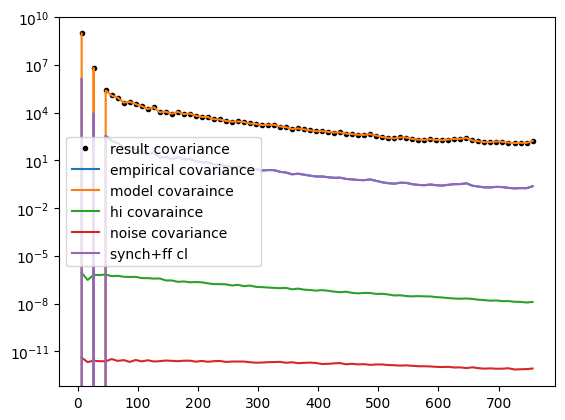

In [478]:
f=10
plt.plot(leff,C_result[:,f,f],'k.', label="result covariance")
plt.plot(leff,dec_sky[:,f,f], label="empirical covariance")
plt.plot(leff,c_model[:,f,f], label="model covaraince")
plt.plot(leff, dec_hi[:,f,f], label="hi covaraince")
plt.plot(leff,dec_noise[:,f,f], label="noise covariance")
plt.plot(leff, dec_fgds[:,f,f], label="synch+ff cl")
plt.yscale('log')
plt.legend()

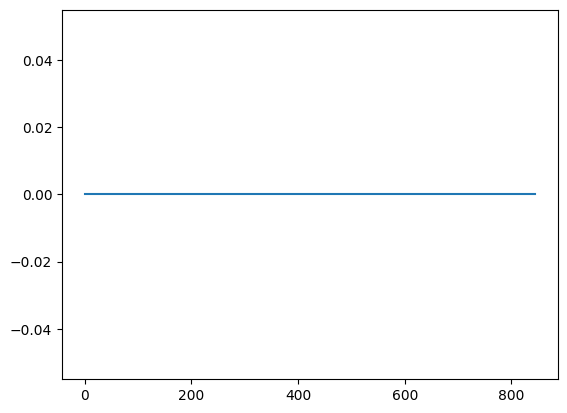

In [458]:
# plt.plot(params_pca)
plt.plot((params_pca-res.x)/params_pca)

# EXTRA

In [431]:
# cube: (n_freq, n_pix)
cube_clean = sky_masked - np.mean(sky_masked, axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(cube_clean, full_matrices=False)
n_modes = 3  # remove first few smooth modes
cube_fg_removed = cube_clean - (U[:, :n_modes] @ np.diag(S[:n_modes]) @ Vt[:n_modes, :])

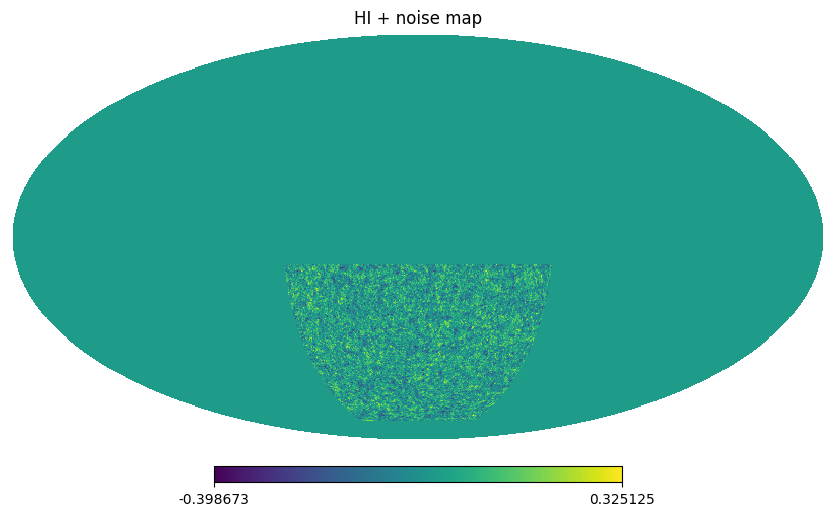

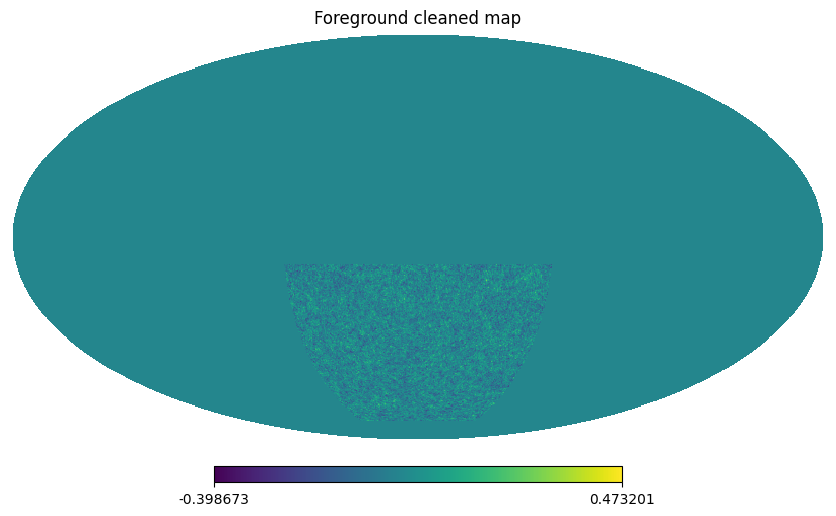

In [445]:
hp.mollview(hi_masked[0]+noise_masked[0], title="HI + noise map")
max= np.max(hi_masked[0]+noise_masked[0])
min= np.min(hi_masked[0]+noise_masked[0])
hp.mollview(cube_fg_removed[0], title="Foreground cleaned map", min=min, max=max)

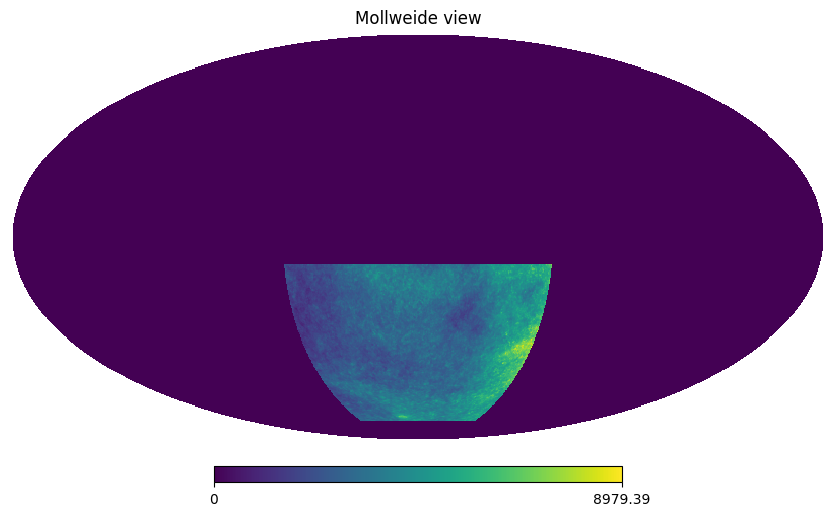

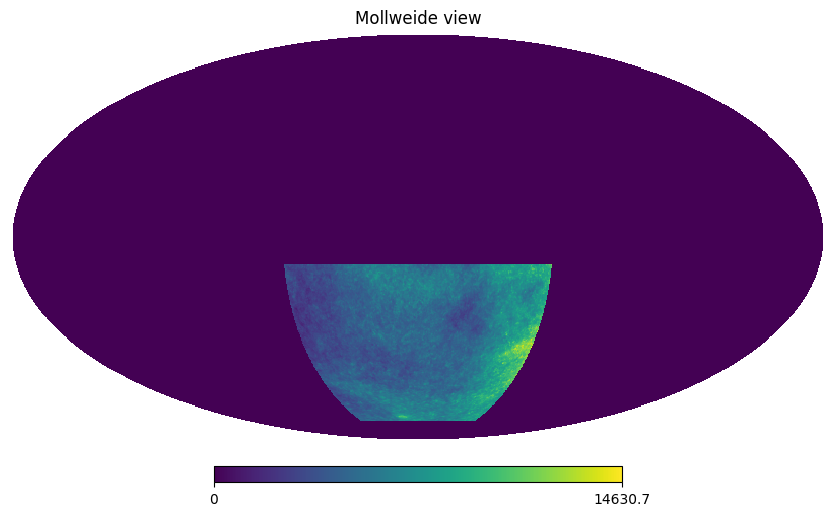

In [437]:
hp.mollview(-cube_fg_removed[0]+cube_clean[0])
hp.mollview(fgds_masked[0])